# Importing libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image
import numpy as np
import time
import datetime

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, concatenate, Masking, Dense, Embedding, LSTM

seed=42

# Importing the data

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Run this cell to load the dataset

path='gdrive/MyDrive/Data/'
NUM_EXAMPLES = 20000
data_examples = []
with open(path+'deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [4]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

# Text Processing

In [6]:
english_list=[]
german_list=[]

for i in data_examples:
  english, german = i.split('\t')[:2]

  english = preprocess_sentence(english)
  german = preprocess_sentence(german)

  english_list.append(english)
  german_list.append('<start> ' + german + ' <end>')

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(german_list)
german_token= tokenizer.texts_to_sequences(german_list)

In [7]:
for idx in np.random.choice(range(len(english_list)),replace=False,size=5):
  print('English: \t', english_list[idx])
  print('German: \t', german_list[idx])
  print('German Tokens:\t', german_token[idx])
  print('-'*60)

English: 	 tom chose wisely .
German: 	 <start> tom waehlte gut . <end>
German Tokens:	 [1, 5, 1796, 49, 3, 2]
------------------------------------------------------------
English: 	 tom is resilient .
German: 	 <start> tom ist belastbar . <end>
German Tokens:	 [1, 5, 6, 5248, 3, 2]
------------------------------------------------------------
English: 	 tom lit a match .
German: 	 <start> tom zuendete ein streichholz an . <end>
German Tokens:	 [1, 5, 1733, 19, 4583, 36, 3, 2]
------------------------------------------------------------
English: 	 catch the ball .
German: 	 <start> fangt den ball . <end>
German Tokens:	 [1, 1781, 53, 537, 3, 2]
------------------------------------------------------------
English: 	 he fixed the net .
German: 	 <start> er reparierte das netz . <end>
German Tokens:	 [1, 14, 4768, 11, 2369, 3, 2]
------------------------------------------------------------


In [8]:
padded_german_token= np.array(pad_sequences(german_token, padding='post'))
print('Shape Of Padded Sequence= ', padded_german_token.shape)
print('Padded Sequence:\n', padded_german_token)

Shape Of Padded Sequence=  (20000, 14)
Padded Sequence:
 [[   1  405    9 ...    0    0    0]
 [   1 3155  663 ...    0    0    0]
 [   1  975    9 ...    0    0    0]
 ...
 [   1    4   15 ...    0    0    0]
 [   1    4   18 ...    0    0    0]
 [   1    4   18 ...    0    0    0]]


# Preparing the Data

### Load The Embedding Layer

In [9]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [10]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

### Preparing train and validation sets

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(english_list, padded_german_token, test_size=0.2, random_state=seed)

train_set= tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_set= tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [12]:
max_len= 13
def data_preprocess(dataset, batch_size):

  def split_set(x,y):
    return tf.strings.split(x),y

  def form_embedding(x,y):
    return embedding_layer(x),y

  def filtering(x,y):
    return tf.less_equal(len(x),max_len)

  def padding_seq(x,y):
    paddings= ((max_len-len(x),0),(0,0))
    return tf.pad(x,paddings=paddings),y

  return dataset.map(split_set).map(form_embedding).filter(filtering).map(padding_seq).batch(batch_size, drop_remainder=True)

In [13]:
train_set= data_preprocess(train_set,16)
test_set= data_preprocess(test_set,16)

print('Element Specs')
print(train_set.element_spec)
print(test_set.element_spec)

Element Specs
(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))
(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))


In [14]:
print('Shape of training set: ', next(iter(train_set.take(1)))[0].shape, end='\n\n')
print('German Data Example:', next(iter(test_set.take(1)))[1])

Shape of training set:  (16, 13, 128)

German Data Example: tf.Tensor(
[[   1    4   18   20  115  178    3    2    0    0    0    0    0    0]
 [   1    4   61  315    3    2    0    0    0    0    0    0    0    0]
 [   1    5    6  831    3    2    0    0    0    0    0    0    0    0]
 [   1   42  457    9    2    0    0    0    0    0    0    0    0    0]
 [   1   78 4750    3    2    0    0    0    0    0    0    0    0    0]
 [   1    5  414   20   75   36    3    2    0    0    0    0    0    0]
 [   1    6   47  312    5    7    2    0    0    0    0    0    0    0]
 [   1  120   21   76   90    9    2    0    0    0    0    0    0    0]
 [   1    4  766   11  113    3    2    0    0    0    0    0    0    0]
 [   1    8  308  129    3    2    0    0    0    0    0    0    0    0]
 [   1    4  580    3    2    0    0    0    0    0    0    0    0    0]
 [   1   64   22  100   45    3    2    0    0    0    0    0    0    0]
 [   1    5   16   19  955    3    2    0    0    0  

# Creating The Custom Layer

In [16]:
class EndTokenLayer(Layer):

  def __init__(self, **kwargs):
    super(EndTokenLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.end_embed= self.add_weight(shape=(1,1,input_shape[-1]), trainable=True, initializer='random_uniform')

  def call(self, inputs):
    tile_end_embed= tf.tile(self.end_embed, (tf.shape(inputs)[0],1,1))
    return tf.concat([inputs, tile_end_embed], axis=1)


In [17]:
end_embed_l= EndTokenLayer()

for i,j in train_set.take(1):
  print('Before embedding: ',i.shape)
  print('After embedding: ', end_embed_l(i).shape)

Before embedding:  (16, 13, 128)
After embedding:  (16, 14, 128)


# Building The Encoder Network

In [18]:
def get_encoder_model(input_shape):

  inputs= Input(input_shape)
  x= EndTokenLayer()(inputs)
  x= Masking()(x)
  x, hidden, cell= LSTM(units=512, return_state=True)(x)

  model= Model(inputs=inputs, outputs=[hidden, cell])
  return model

In [19]:
encoder= get_encoder_model((max_len,128))

x,y= next(iter(train_set.take(1)))
print('Example shape:\t', x.shape)
print('Shape of resulting tensor:\t', [i.shape for i in encoder(x)])

Example shape:	 (16, 13, 128)
Shape of resulting tensor:	 [TensorShape([16, 512]), TensorShape([16, 512])]


In [20]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
end_token_layer_1 (EndTokenL (None, 14, 128)           128       
_________________________________________________________________
masking (Masking)            (None, 14, 128)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


# Building The Decoder Network

In [22]:
class Decoder(Model):

  def __init__(self, german, **kwargs):
    super(Decoder, self).__init__(**kwargs)
    self.embed= Embedding(german, 128, mask_zero=True)
    self.lstm= LSTM(512, return_state=True, return_sequences=True)
    self.dense= Dense(german)

  def call(self, inputs, hidden=None, cell=None):
    x=self.embed(inputs)
    if hidden is not None and cell is not None:
      x, hidden_state, cell_state= self.lstm(inputs=x, initial_state=[hidden, cell])
    else:
      x, hidden_state, cell_state= self.lstm(inputs=x)
    x=self.dense(x)

    return (x,hidden_state,cell_state)

In [23]:
german_voc= len(tokenizer.word_index)+1
decoder= Decoder(german_voc)

for i,j in train_set.take(1):
  print('Input shape:\t', i.shape)
  h,c= encoder(i)
  print('Encoder shape:\t', h.shape, c.shape)
  out, h, c= decoder(j, h, c)
  print('Decoder shape:\t', out.shape, h.shape, c.shape)

Input shape:	 (16, 13, 128)
Encoder shape:	 (16, 512) (16, 512)
Decoder shape:	 (16, 14, 5744) (16, 512) (16, 512)


In [24]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


# Making A Custom Training Loop

In [25]:
def decoder_process(dat):
  return dat[:,:-1],dat[:,1:]

In [26]:
loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

@tf.function
def grad(eng_input, ger_input, ger_output):
  global encoder, decoder
  with tf.GradientTape() as tape:
    hidden_state, cell_state= encoder(eng_input)
    ger_pred, _, _ = decoder(ger_input, hidden_state, cell_state)
    losses=loss(ger_output, ger_pred)
    gradients= tape.gradient(losses, encoder.trainable_variables+decoder.trainable_variables)

    return losses,gradients

In [29]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)

def training_loop(train, test, epochs, optimizer, loss):

  epoch_training_losses = []
  epoch_test_losses = []

  for epoch in range(epochs):
    start = time.time()
    train_losses = tf.keras.metrics.Mean()
    val_losses = tf.keras.metrics.Mean()

    for x, y in train:
      y_in, y_out = decoder_process(y)
      losses, grads = grad(x, y_in, y_out)
      optimizer.apply_gradients(zip(grads, encoder.trainable_variables+decoder.trainable_variables))
      train_losses(losses)
    epoch_training_losses.append(train_losses.result())

    for x, y in test:
      y_in, y_out = decoder_process(y)
      losses, _ = grad(x,y_in, y_out)
      val_losses(losses)
    epoch_test_losses.append(val_losses.result())

    end = str(datetime.timedelta(seconds=time.time()-start))
    print(f'EPOCH: {epoch+1:03d} TIME: {end} Training Loss: {train_losses.result():.2f}  Validation Loss: {val_losses.result():.2f}')
  return epoch_training_losses, epoch_test_losses

In [30]:
epochs=10
train_loss, test_loss = training_loop(train_set, test_set, epochs, optimizer, loss)

EPOCH: 001 TIME: 0:03:58.228143 Training Loss: 5.47  Validation Loss: 4.82
EPOCH: 002 TIME: 0:03:02.996051 Training Loss: 4.30  Validation Loss: 3.95
EPOCH: 003 TIME: 0:04:03.001590 Training Loss: 3.41  Validation Loss: 3.22
EPOCH: 004 TIME: 0:03:07.858749 Training Loss: 2.58  Validation Loss: 2.55
EPOCH: 005 TIME: 0:04:02.994716 Training Loss: 1.84  Validation Loss: 1.97
EPOCH: 006 TIME: 0:04:02.990476 Training Loss: 1.21  Validation Loss: 1.52
EPOCH: 007 TIME: 0:03:58.190040 Training Loss: 0.77  Validation Loss: 1.26
EPOCH: 008 TIME: 0:03:58.272620 Training Loss: 0.51  Validation Loss: 1.13
EPOCH: 009 TIME: 0:03:02.473329 Training Loss: 0.36  Validation Loss: 1.08
EPOCH: 010 TIME: 0:03:57.987185 Training Loss: 0.26  Validation Loss: 1.07


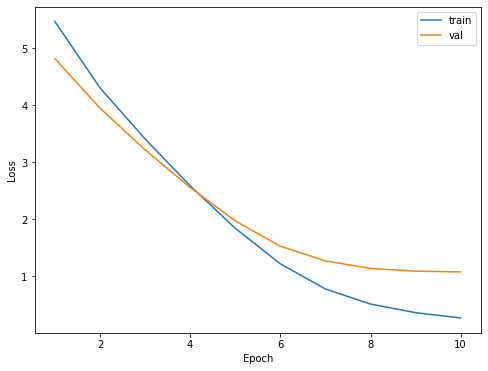

In [31]:
import matplotlib.pyplot as plt

x = range(1, len(train_loss)+1)
plt.figure(figsize=(8,6))
plt.plot(x, train_loss, label='train')
plt.plot(x, test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Using The Model For Translation

In [79]:
example= 10
indices = np.random.randint(0, len(english_list) -1, example)
eng_sample = np.array(english_list)[indices]
ger_sample = np.array(german_list)[indices]

ger_sample_tokens = tokenizer.texts_to_sequences(ger_sample)
padded_ger_sample = np.array(pad_sequences(ger_sample_tokens,padding='post'))

sample_dataset = tf.data.Dataset.from_tensor_slices((eng_sample, padded_ger_sample))
sample_dataset = data_preprocess(sample_dataset,1)

# get the length of longest padded german token sequence
x, y = next(iter(test_set))
max_trans_length = len(y)

# translation
sentence_counter = 0
for x, y in sample_dataset:
    h_state, c_state = encoder(x)
    word_string = [1]
    word_string[0] = 1
    for i in range(max_trans_length -1):
        input_string = tf.convert_to_tensor(np.array([word_string]), dtype = 'int32')
        output, h_state, c_state = decoder(input_string, hidden = h_state, cell = c_state)
        word_string.append (np.argmax(output[0][-1]))
        if np.argmax(output[0][-1]) == 2:
          break

    print('English:\t', eng_sample[sentence_counter])
    print('German:\t\t', ger_sample[sentence_counter])
    print('Predicted German:\t', tokenizer.sequences_to_texts([word_string])[0])
    print('-' * 60)
    sentence_counter+=1


English:	 tom is secretive .
German:		 <start> tom ist geheimnisvoll . <end>
Predicted German:	 <start> tom ist aus die boden . <end>
------------------------------------------------------------
English:	 they agree .
German:		 <start> sie stimmen zu . <end>
Predicted German:	 <start> sie sich . <end>
------------------------------------------------------------
English:	 tom got cheated .
German:		 <start> tom wurde betrogen . <end>
Predicted German:	 <start> tom fallen . <end>
------------------------------------------------------------
English:	 tom lived alone .
German:		 <start> tom lebte allein . <end>
Predicted German:	 <start> tom allein . <end>
------------------------------------------------------------
English:	 i saw an airplane .
German:		 <start> ich habe ein flugzeug gesehen . <end>
Predicted German:	 <start> ich habe . <end>
------------------------------------------------------------
English:	 i like your style .
German:		 <start> ich mag deinen stil . <end>
Predicted G